<a href="https://colab.research.google.com/github/daavalossa/ApredizajeAutomatico/blob/main/ExamenFinalAprendizajeDannyAvalos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet



def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

Cargamos los Datos y exploración inicial

In [220]:
#gdrive location:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [221]:
df.tail()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.65,0.1343,12,37,49


In [222]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


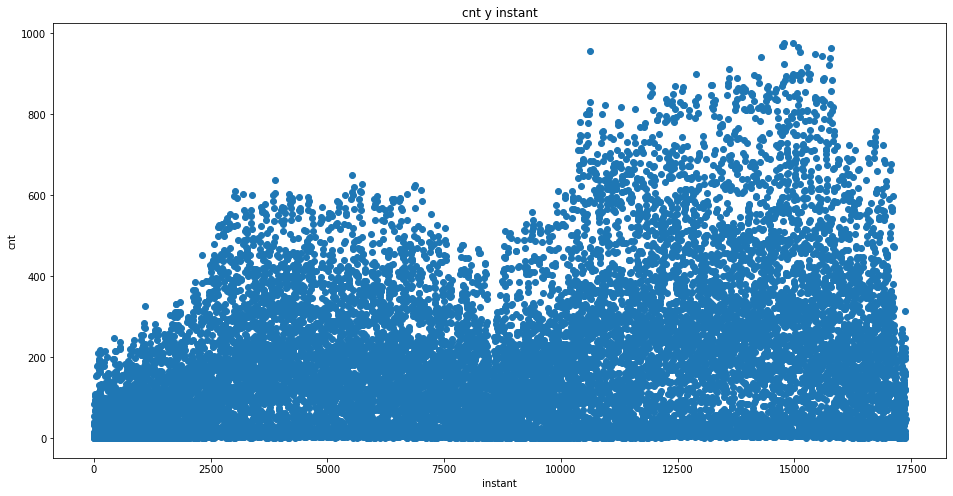

In [223]:
x = 'instant'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

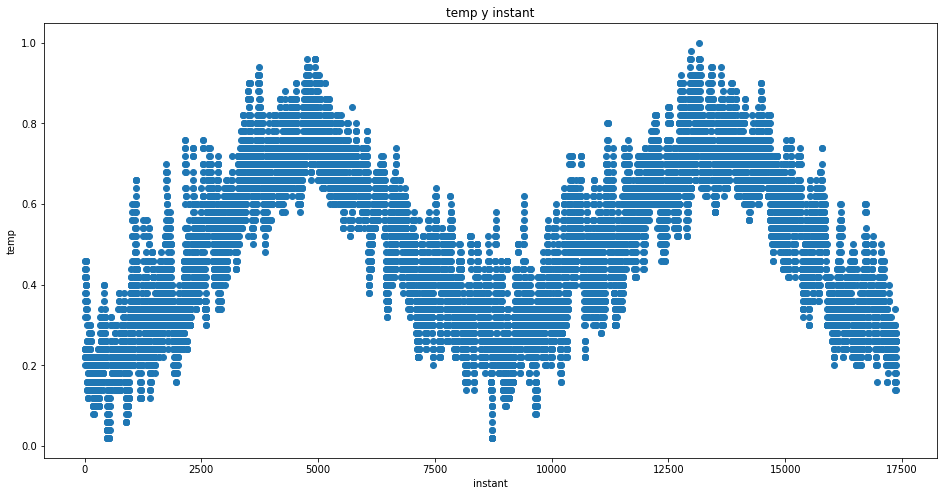

In [224]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

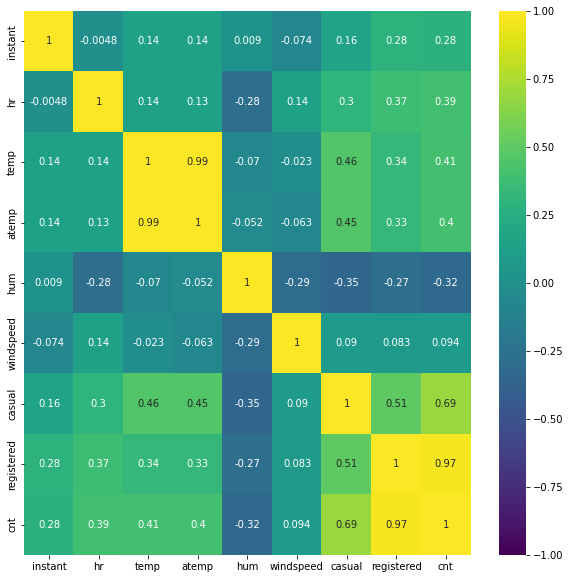

In [225]:

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

In [226]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [227]:
df_byday

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [228]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


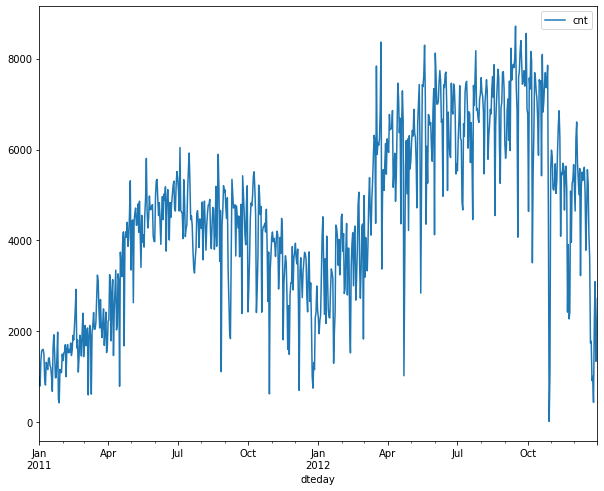

In [229]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

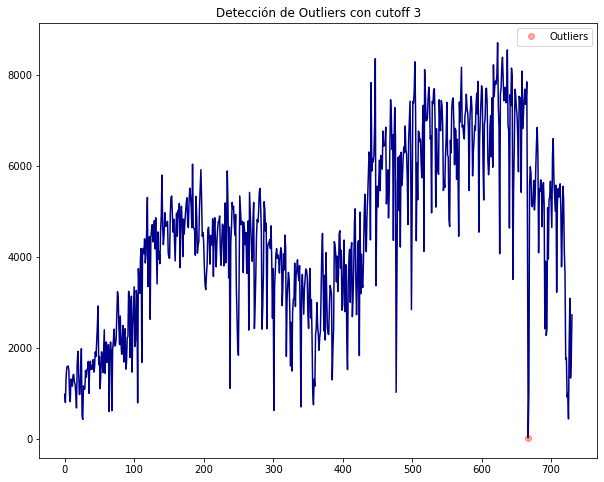

In [230]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [231]:
df['dteday']=pd.to_datetime(df['dteday'], format='%Y-%m-%d')

In [232]:
df.isnull()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
17374,False,False,False,False,False,False,False,False,False,False,False
17375,False,False,False,False,False,False,False,False,False,False,False
17376,False,False,False,False,False,False,False,False,False,False,False
17377,False,False,False,False,False,False,False,False,False,False,False


In [233]:
df.isnull().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

In [234]:
#Para las variables numéricas utilizo la media para reemplazar los nulos
df.fillna(df.mean(), inplace = True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [235]:
for column in df.columns:
        df[column].fillna(df[column].mode()[0], inplace= True)


In [236]:
df.isnull().sum()

instant       0
dteday        0
hr            0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17379 non-null  object        
 4   temp        17379 non-null  float64       
 5   atemp       17379 non-null  float64       
 6   hum         17379 non-null  float64       
 7   windspeed   17379 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [238]:
print(df.head(2))

   instant     dteday  hr                                       weathersit  \
0        1 2011-01-01   0  Clear, Few clouds, Partly cloudy, Partly cloudy   
1        2 2011-01-01   1  Clear, Few clouds, Partly cloudy, Partly cloudy   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40  


In [239]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [240]:
dfy = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day

In [241]:
dfy= dfy.rename(columns={'dteday':'ds','cnt':'y'})

In [242]:
dfy

,ds,y
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [243]:
dfy

,ds,y
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [244]:
m = Prophet()
m.fit(dfy)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yoqf8ro/l2yiphzm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7yoqf8ro/nigrzwwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79619', 'data', 'file=/tmp/tmp7yoqf8ro/l2yiphzm.json', 'init=/tmp/tmp7yoqf8ro/nigrzwwn.json', 'output', 'file=/tmp/tmp7yoqf8ro/prophet_modelxkdom57y/prophet_model-20221031052201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:22:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [245]:
future = m.make_future_dataframe(periods=14)
future.tail()

,ds
740,2013-01-10
741,2013-01-11
742,2013-01-12
743,2013-01-13
744,2013-01-14


In [246]:
# Realizamos el forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
740,2013-01-10,4987.695197,3658.124299,6254.550517
741,2013-01-11,5092.598636,3805.063541,6351.104138
742,2013-01-12,5073.310032,3836.512791,6258.761351
743,2013-01-13,4821.581114,3515.938400,6034.779352
744,2013-01-14,4993.998842,3798.788531,6193.198951


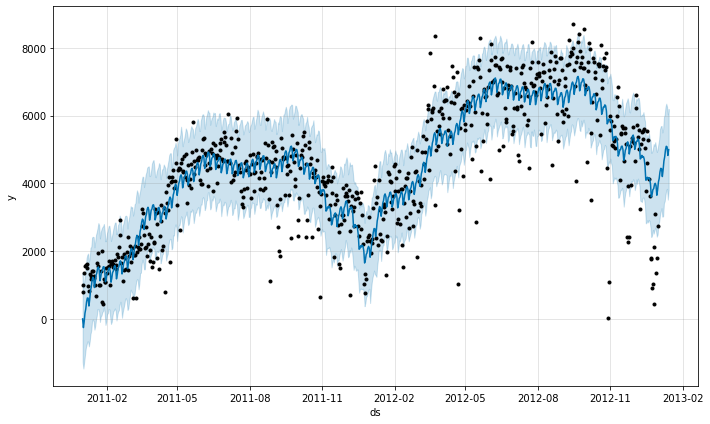

In [247]:
fig1 = m.plot(forecast)

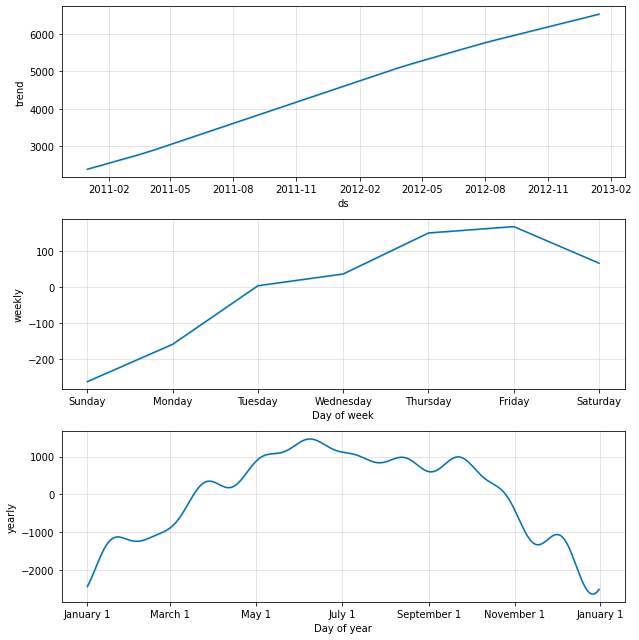

In [248]:
fig2 = m.plot_components(forecast)

In [151]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [249]:
import plotly 

# Si tienes plotly instalado, incluso puedes realizar plots interactivos!
# Para instalar plotly simplemente utiliza pip install plotly
from prophet.plot import plot_plotly

plot_plotly(m, forecast)
